In [1]:
import numpy as npimport
import yfinance as yf
import numpy as np
import cvxpy as cp
import random
import matplotlib.pyplot as plt
import cvxpy as cp
import pandas as pd

### Extracting Data

In [3]:
#getting stocks data
tickers = ["ADRO.JK", "ANTM.JK", "ASII.JK",
           "BBCA.JK", "BBNI.JK", "BBRI.JK",
           "BBTN.JK", "BMRI.JK", "BRPT.JK",
           "BUKA.JK", "CPIN.JK", "EMTK.JK",
           "EXCL.JK", "ICBP.JK", "INCO.JK",
           "INDF.JK", "INKP.JK", "KLBF.JK",
           "MDKA.JK", "MIKA.JK", "PGAS.JK",
           "PTBA.JK", "SMGR.JK", "TBIG.JK",
           "TINS.JK", "TLKM.JK", "TOWR.JK",
           "UNTR.JK", "UNVR.JK", "WSKT.JK" ]

data0  = yf.download(tickers, start="2020-01-01", end="2025-01-01")
close0 = data0["Close"]
close0 = close0.dropna()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  30 of 30 completed


In [4]:
#returns/miu before filtered
monthly_close0 = close0.resample('ME').last()
returns0 = []
miu0 = []

for ticker in tickers:
    prices = monthly_close0[ticker].values
    logret = np.log(prices[1:] / prices[:-1]) * 100
    returns0.append(logret)
    miu0.append(np.mean(logret))

returns0 = np.array(returns0)
miu0 = np.array(miu0)
corr_matrix = np.corrcoef(returns0)

### Filtering Data

In [6]:
alpha_values = [0.9, 0.95, 0.99]
threshold_values = [0.3, 0.5, 0.7]

In [7]:
def filter_by_threshold(thresh):
    to_drop = set()
    for i in range(n_assets):
        for j in range(i + 1, n_assets):
            if corr_matrix[i, j] > thresh:
                if miu0[i] > miu0[j]:
                    to_drop.add(j)
                elif miu0[i] < miu0[j]:
                    to_drop.add(i)
                else:
                    to_drop.add(j)  # arbitrary
    keep_indices = [i for i in range(n_assets) if i not in to_drop]
    filtered_tickers = [tickers[i] for i in keep_indices]
    return filtered_tickers

In [8]:
n_assets = returns0.shape[0]
filtered_ticker_lists = []
for t in threshold_values:
    filtered_ticker_lists.append(filter_by_threshold(t))
print(filtered_ticker_lists)

[['ADRO.JK', 'BMRI.JK', 'BRPT.JK', 'CPIN.JK', 'EXCL.JK', 'ICBP.JK', 'MIKA.JK', 'TBIG.JK', 'TOWR.JK'], ['ADRO.JK', 'ASII.JK', 'BMRI.JK', 'BRPT.JK', 'BUKA.JK', 'CPIN.JK', 'EMTK.JK', 'EXCL.JK', 'ICBP.JK', 'INKP.JK', 'KLBF.JK', 'MIKA.JK', 'PGAS.JK', 'TBIG.JK', 'TINS.JK', 'TLKM.JK', 'TOWR.JK', 'UNVR.JK'], ['ADRO.JK', 'ANTM.JK', 'ASII.JK', 'BBCA.JK', 'BBRI.JK', 'BMRI.JK', 'BRPT.JK', 'BUKA.JK', 'CPIN.JK', 'EMTK.JK', 'EXCL.JK', 'ICBP.JK', 'INCO.JK', 'INDF.JK', 'INKP.JK', 'KLBF.JK', 'MDKA.JK', 'MIKA.JK', 'PGAS.JK', 'PTBA.JK', 'SMGR.JK', 'TBIG.JK', 'TINS.JK', 'TLKM.JK', 'TOWR.JK', 'UNVR.JK', 'WSKT.JK']]


### Optimize All Portofolio

In [10]:
n_points = int(input("berapa banyak titik Portofolio Returns :"))

berapa banyak titik Portofolio Returns : 50


In [11]:
from scipy.optimize import linprog
import numpy as np
import yfinance as yf

def CVaR_Rp(ticker_list, alpha, n_points):
    CVaR_list = []
    ValidRp_list = []
    weight_list = []

    # Fetch and process return data
    data  = yf.download(ticker_list, start="2020-01-01", end="2025-01-01")
    close = data["Close"].dropna()
    monthly_close = close.resample('ME').last()

    returns = []
    miu = []

    for ticker in ticker_list:
        prices = monthly_close[ticker].values
        logret = np.log(prices[1:] / prices[:-1]) * 100
        returns.append(logret)
        miu.append(np.mean(logret))

    returns = np.array(returns)  # shape: (n_assets, n_periods)
    miu = np.array(miu)
    n_assets, N_scenarios = returns.shape

    Rp_list = np.linspace(np.min(miu), np.max(miu), n_points)

    for Rp in Rp_list:
        # LP variables: [w_1, ..., w_n, zeta, u_1, ..., u_N]
        c = np.hstack([
            np.zeros(n_assets),                # weights
            [1.0],                             # zeta
            np.ones(N_scenarios) / ((1 - alpha) * N_scenarios)  # u_i
        ])

        # Inequality constraints: -rᵢᵀw - zeta - uᵢ ≤ 0
        A_ub = np.zeros((N_scenarios, n_assets + 1 + N_scenarios))
        b_ub = np.zeros(N_scenarios)
        for i in range(N_scenarios):
            A_ub[i, :n_assets] = -returns[:, i]
            A_ub[i, n_assets] = -1
            A_ub[i, n_assets + 1 + i] = -1

        # Equality constraints
        A_eq = np.zeros((2, n_assets + 1 + N_scenarios))
        b_eq = np.zeros(2)
        A_eq[0, :n_assets] = 1        # sum(w) = 1
        b_eq[0] = 1
        A_eq[1, :n_assets] = miu      # expected return = Rp
        b_eq[1] = Rp

        # Variable bounds: w_i ≥ 0, zeta free, u_i ≥ 0
        bounds = [(0, None)] * n_assets + [(None, None)] + [(0, None)] * N_scenarios

        # Solve the LP
        result = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                         bounds=bounds, method='highs')

        if result.success:
            CVaR_list.append(result.fun)
            ValidRp_list.append(Rp)
            weight_list.append(result.x[:n_assets])

    return [CVaR_list, ValidRp_list]


def CVaR_Rp(ticker_list, alpha):
    CVaR_list = []
    ValidRp_list = []
    weight_list = []

    returns = []
    miu = []

    data  = yf.download(ticker_list, start="2020-01-01", end="2025-01-01")
    close = data["Close"]
    close = close.dropna()
    monthly_close = close.resample('ME').last()
    for ticker in ticker_list:
        prices = monthly_close[ticker].values
        logret = np.log(prices[1:] / prices[:-1]) * 100
        returns.append(logret)
        miu.append(np.mean(logret))    

    returns = np.array(returns)
    miu = np.array(miu)

    n_assets = len(ticker_list)
    N_scenarios = returns.shape[1]
        
    Rp_list = []
    a = np.min(miu)
    b = np.max(miu)
    Rp_list = np.linspace(a, b, n_points)
    for i in Rp_list:
        x = cp.Variable(n_assets)
        u = cp.Variable(N_scenarios)
        zeta = cp.Variable()
    
        losses = -miu @ x       

        cvar = zeta + (1 / ((1 - alpha) * N_scenarios)) * cp.sum(u)
        constraints = [
            cp.sum(x) == 1,
            x >= 0,
            u >= 0,
            u >= losses - zeta,
            x.T @ miu >= i,
        ]
        problem = cp.Problem(cp.Minimize(cvar), constraints)
        result = problem.solve()

        if problem.status == "optimal":
            CVaR = result
            CVaR_list.append(CVaR)
            ValidRp_list.append(i) 
            weight_list.append(x.value)
    return [CVaR_list, ValidRp_list]

In [13]:
ALL_THE_DATA = []
for i in filtered_ticker_lists:
    for alpha in alpha_values:
        ALL_THE_DATA.append(CVaR_Rp(i,alpha,n_points))

[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  18 of 18 completed
[*********************100%***********************]  18 of 18 completed
[*********************100%***********************]  18 of 18 completed
[*********************100%***********************]  27 of 27 completed
[*********************100%***********************]  27 of 27 completed
[*********************100%***********************]  27 of 27 completed


### Graphing

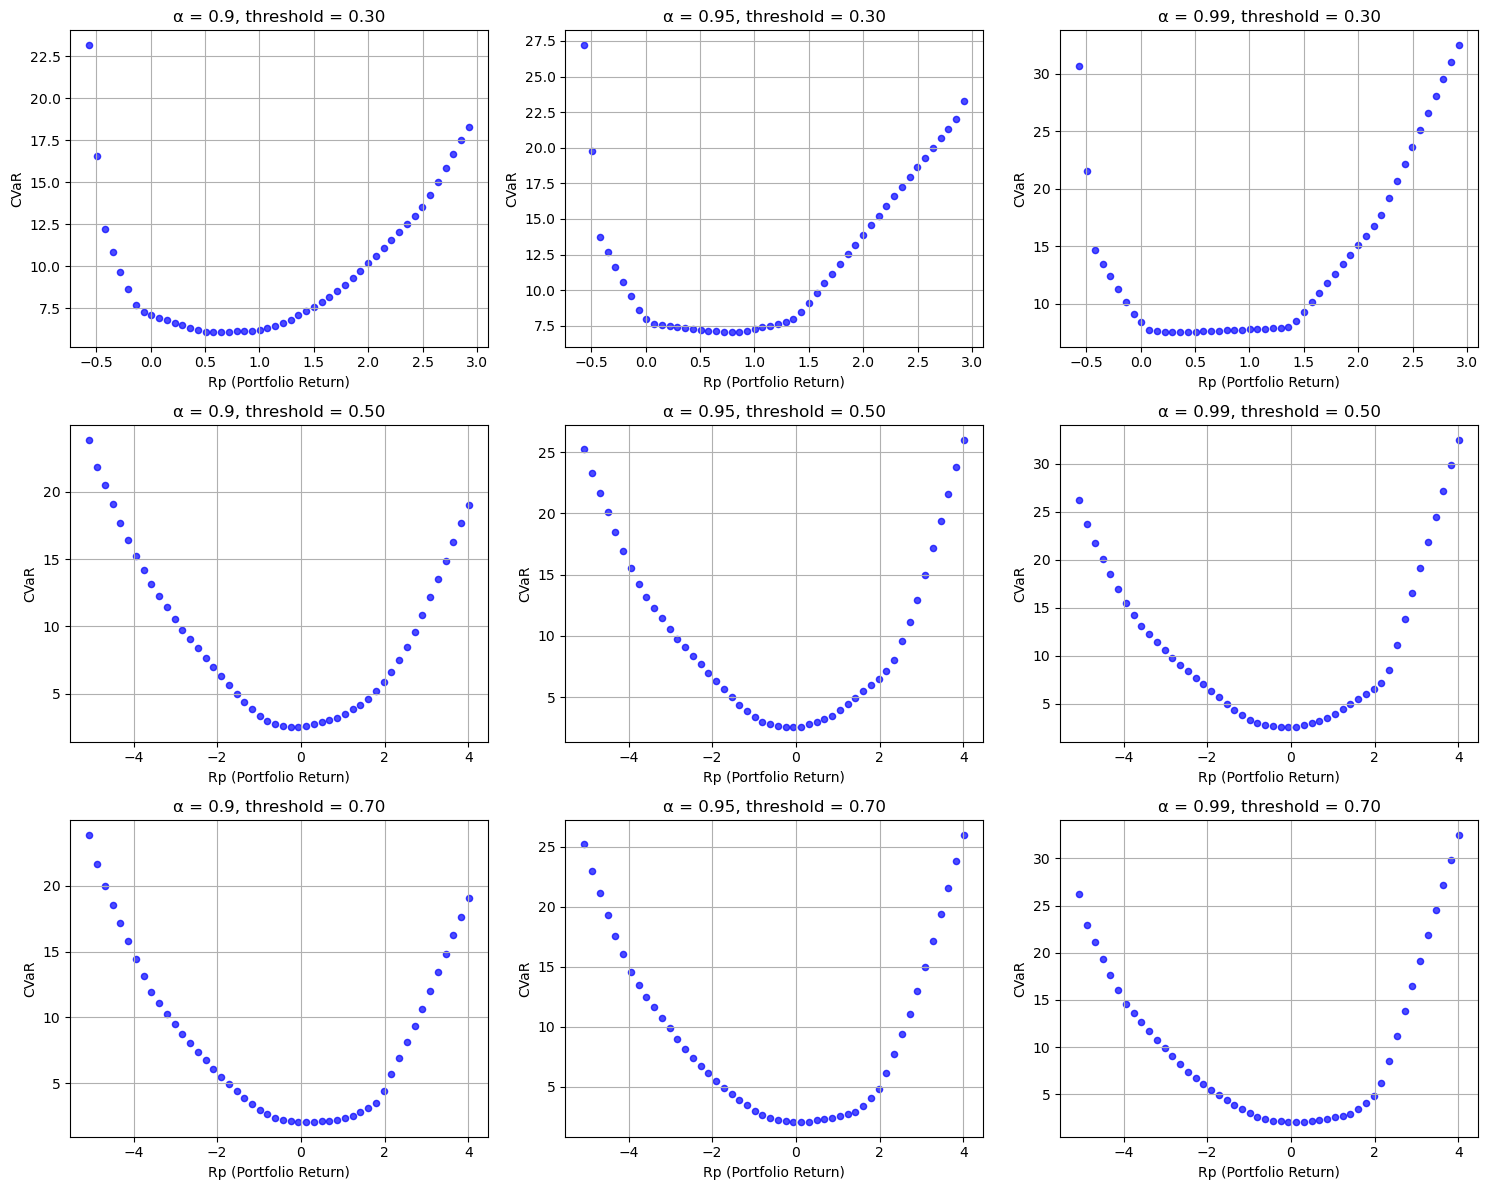

In [15]:
n = len(ALL_THE_DATA)
n_rows = int(np.ceil(np.sqrt(n)))
n_cols = int(np.ceil(n / n_rows))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

n_alpha = len(alpha_values)

for i, (cvar_list, rp_list) in enumerate(ALL_THE_DATA):
    threshold = threshold_values[i // n_alpha]
    alpha = alpha_values[i % n_alpha]
    
    ax = axes[i]
    ax.scatter(rp_list, cvar_list, alpha=0.7, color='blue', s=20)
    ax.set_title(f"α = {alpha}, threshold = {threshold:.2f}")
    ax.set_xlabel("Rp (Portfolio Return)")
    ax.set_ylabel("CVaR")
    ax.grid(True)

# Hide extra subplots
for j in range(n, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()